# In vivo recordings

#### **Basic instructions:**
#### 1. **To run code windows/blocks:** 

    - you can either hit the play button to the left of the code window 

    - or you can use they keyboard shortcut: select the block and press 'shift-enter'.

#### 2. **The first time** you run this code notebook, you might get a popup asking to choose which version of Python to use (the python "kernel"). **Just hit enter** to choose the base/default version.

#### 3. Make sure you data (.abf) files are in the "data" folder here on the left. You can just copy/paste the files from where they are saved on your computer.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils import *
update_plot_defaults()
%load_ext autoreload
%autoreload 2

## 1. Choose the data file you want to analyze

#### Put the .abf files with your recordings in the "data/13-In_vivo" folder

In [76]:
data_folder = "data/13-In_vivo"

import os
print("Folders:")
for subdir in os.listdir(data_folder):
    if os.path.isdir(data_folder + "/" + subdir):
        print(f"'{data_folder}/{subdir}'")

from glob import glob
print("Files:")
data_files = glob(data_folder+"/*.h5")
data_files.sort()
data_files

Folders:
Files:


['data/13-In_vivo/MA4_0001.h5',
 'data/13-In_vivo/MP19_0001.h5',
 'data/13-In_vivo/MP1_2025-06-17_0001.h5',
 'data/13-In_vivo/MP2_2025-06-17_0001.h5',
 'data/13-In_vivo/MP6_0001.h5',
 'data/13-In_vivo/MP7_0001.h5',
 'data/13-In_vivo/mp10_2025-06-18_0001.h5',
 'data/13-In_vivo/vsf2_0001.h5']

Choose which file you want to analyze (copy name from above) and paste the file name here:

In [83]:
data_file = 'data/13-In_vivo/vsf2_0001.h5'

Now we can load the file and plot the raw data:

Trace('vsf2_0001.h5')
Data points: 18,262,012
Duration: 913.101 s
Sampling rate: 20000 Hz
Sampling interval: 0.050 ms
Available channels: Current, Voltage


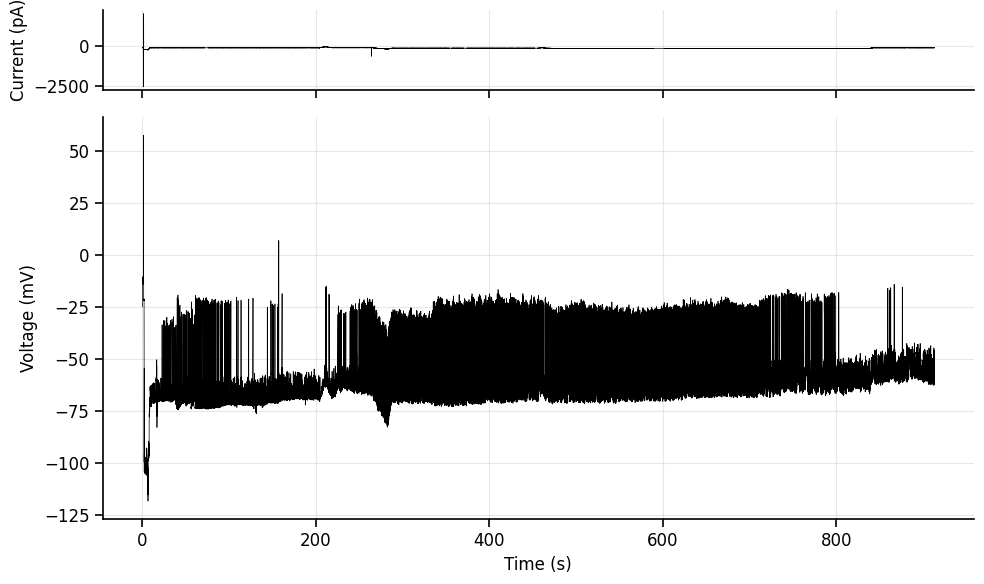

In [84]:
# Load with custom scaling and separate sweeps
traces = Trace.from_wavesurfer_h5_file(data_file, 
                                       voltage_scaling=0.1,
                                       current_scaling=1)
print(traces)
traces = traces.resample(sampling_frequency=10000)

time_units = 's' # specify seconds (s), or milliseconds (ms)

# ----------------------------------------------------------------------------------------------------------------
%matplotlib inline
# %matplotlib widget
ax = traces.plot(plot_voltage=True, plot_current=True, time_units=time_units, sweep='all', height_ratios=[1, 5])
plt.show()

## 2. Signal processing

### First let's crop out the data we want to analyze (get rid of the initial portion before the recording starts)

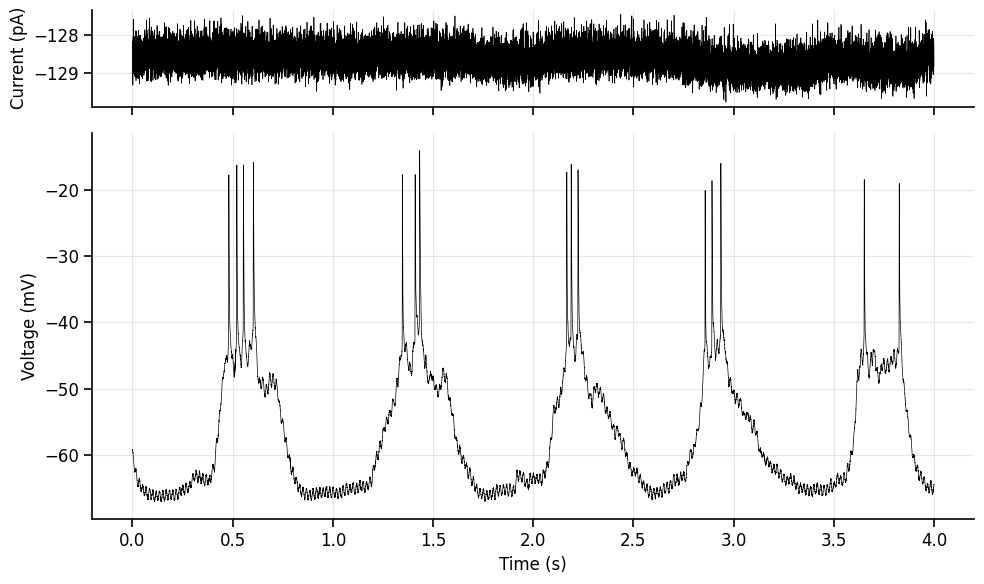

In [66]:
start_time = 5
end_time= 9

# ----------------------------------------------------------------------------------------------------------------
traces = traces.crop(timepoint=start_time, timepoint_2=end_time, time_units=time_units)

%matplotlib inline
ax = traces.plot(plot_voltage=True, plot_current=True, time_units=time_units, sweep='all', height_ratios=[1, 4])
plt.show()


### 2.1. Optional: apply highpass / lowpass / bandpass filtering

Depending in you recording, you may have 50/60 Hz line noise, high-frequency noise, or drift in your recordings.

The goal here is to only remove the noise with minimal distortion of the data, so be careful not to overdo it

In [46]:
apply_filtering = True

You can run this next cell as many times as you want to fine-tune the filtering parameters:

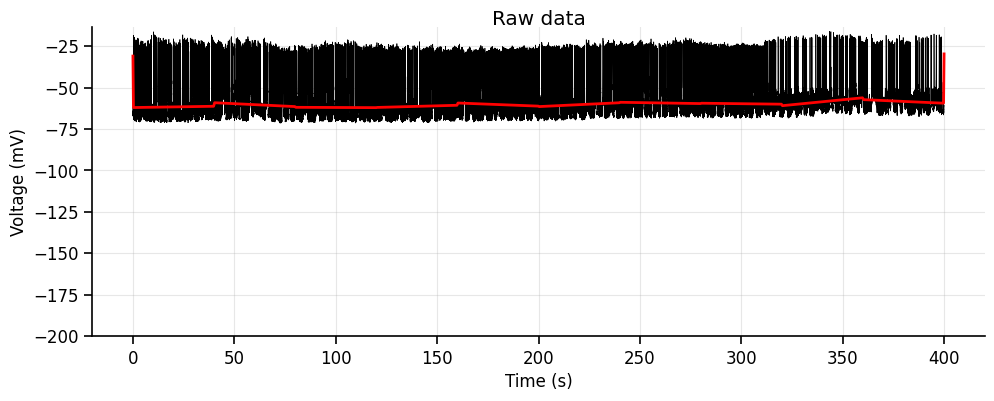

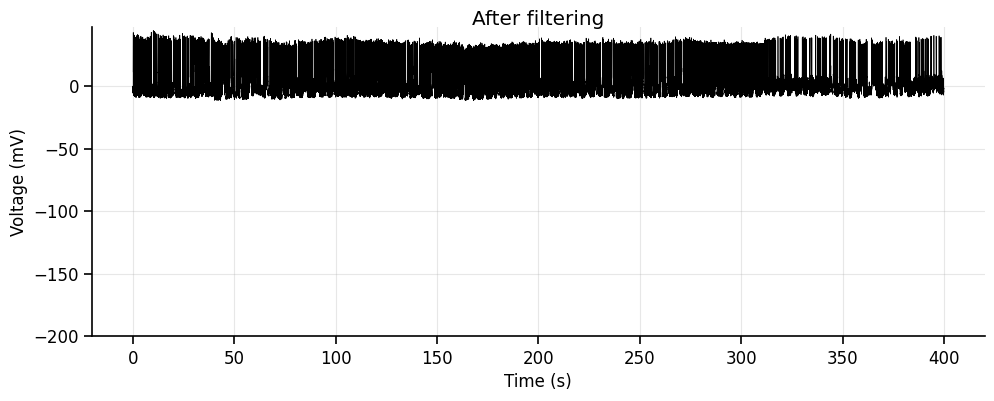

In [47]:
if apply_filtering:
    filtered_traces = traces
    trend = None

    # Step 1: Detrend the data to remove linear or constant trends (e.g slow drift)
    filtered_traces, trend_dict = filtered_traces.detrend(detrend_type='linear', num_segments=10, return_trend=True)

    # Smooth the trend using a boxcar filter
    window_size = 5000
    trend = trend_dict['voltage_trend']
    trend = np.convolve(trend, np.ones(window_size)/window_size, mode='same')

    # Step 2: Lowpass filter (removes high-frequency noise)
    filtered_traces = filtered_traces.lowpass_filter(cutoff_freq = 4000, # Choose a value in units of Hz
                                                    apply_to_voltage=True)

    # Step 3: Bandpass filter (removes 50/60 Hz mainline noise)
    filtered_traces = filtered_traces.filter_line_noise(
        line_freq = 60, # Frequency (Hz) of noise to remove: 50 Hz (in Europe) or 60 Hz (in the US).
        width = 0.5, # Width (Hz) controls the width of frequency bands around the line frequency the filter cuts out.
        method = 'notch', # Options: 'notch' (IIR notch filter), 'bandstop' (Butterworth), or 'fft' (spectral).
        apply_to_voltage=True)

    # # # Step 4: Highpass filter (removes low-frequency oscillations)
    # # # ------------------------------------------------------------
    # # # # Be extra careful with this next one, it tends to distort the data. Use only in case of emergency.
    # # filtered_traces = filtered_traces.highpass_filter(cutoff_freq=0.001)
    # # # ------------------------------------------------------------

    %matplotlib inline
    ax = traces.plot(plot_voltage=True, plot_current=False)
    ax.set_title('Raw data', y=0.98)
    if trend is not None:   
        ax.plot(traces.time, trend, 'r', linewidth=2)
    ax.set_ylim(bottom=-200)
    plt.show()

    ax = filtered_traces.plot(plot_voltage=True, plot_current=False)
    ax.set_title('After filtering', y=0.98)
    ax.set_ylim(bottom=-200)
    plt.show()


Once you are happy with the filter setting, run the next cell to implement them:

In [48]:
if apply_filtering:
    traces=filtered_traces

### 2.2. Optional: apply baseline correction

If your baseline current is not at zero, run the next code blocks to apply a baseline correction.

In [49]:
# Change this to True if you want to subtract the baseline from the sweeps.
subtract_baseline = True
start_baseline = 0
end_baseline = 20

BASELINE SUBTRACTED:
Baseline voltage: 0.05337246168814117


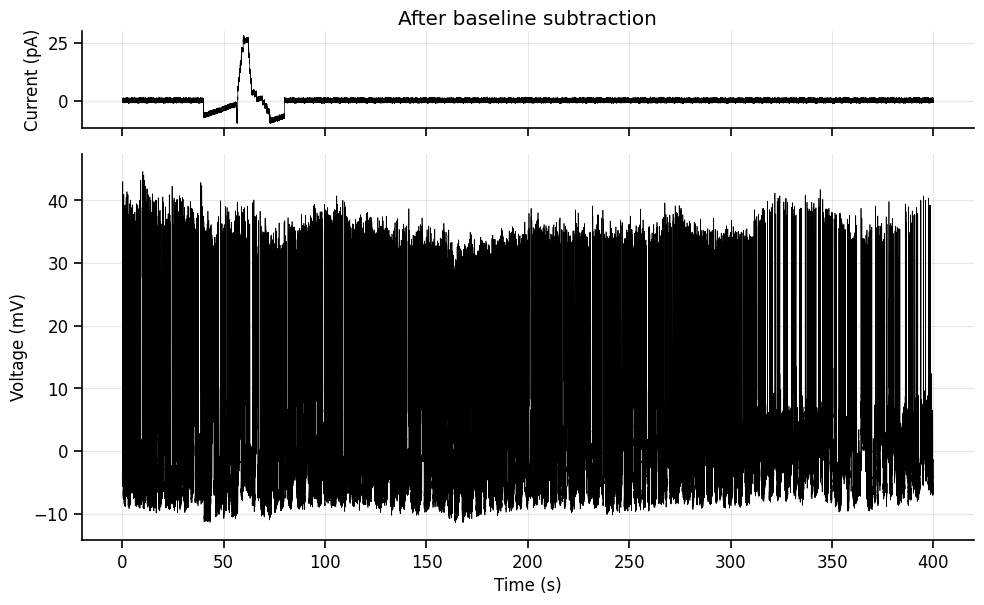

In [50]:
if subtract_baseline:
    traces.subtract_baseline(start_time = start_baseline, 
                             end_time = end_baseline , 
                             time_units = time_units,  # specify seconds (s), or milliseconds (ms)
                             channel = 'voltage')  # Options: 'current', 'voltage', 'all'
    %matplotlib inline
    ax1, ax2 = traces.plot(plot_voltage=True, plot_ttl=False, time_units=time_units, sweep='all', height_ratios=[1,4])
    ax1.set_title('After baseline subtraction', y=0.98)
    plt.show()
else:
    print("BASELINE NOT SUBTRACTED")


## 3. Measure firing rate to get FI curve

In [51]:
spike_results = traces.analyze_action_potentials(min_spike_amplitude=25.0, 
                                                max_width=25.0, 
                                                min_ISI=6, 
                                                headstage=0, 
                                                sweep=None, # None means all sweeps
                                                return_dict=True,
                                                time_units='ms')

spike_results

{'spike_times': array([   186.4,    194.8,    201. , ..., 398558.6, 398568.2, 398577.8]),
 'threshold_voltages': array([-0.381 , -0.0877,  4.4084, ...,  9.1585,  9.0955, 10.0719]),
 'peak_voltages': array([38.4072, 38.4072, 42.9609, ..., 39.1673, 39.1673, 39.1673]),
 'spike_amplitudes': array([38.7881, 38.4949, 38.5525, ..., 30.0089, 30.0718, 29.0954]),
 'spike_widths': array([23.8, 15.3, 24. , ..., 21.7, 12.1,  2.5]),
 'peak_times': array([   208.3,    208.3,    222. , ..., 398578.7, 398578.7, 398578.7])}

Number of events: 2844
Total area above threshold: 348.21
Individual event areas: ['0.82', '0.00', '0.66', '0.83', '0.00', '-0.00', '0.64', '0.00', '0.82', '0.19', '0.00', '-0.00', '0.40', '-0.00', '0.00', '0.46', '0.79', '0.66', '0.00', '0.01', '0.78', '0.65', '0.85', '0.93', '0.01', '0.00', '0.00', '0.09', '0.57', '0.38', '0.21', '-0.00', '0.37', '0.00', '1.00', '0.86', '0.58', '0.00', '0.80', '0.73', '0.51', '0.00', '0.00', '0.59', '0.73', '0.29', '0.52', '0.15', '0.24', '0.26', '0.74', '0.59', '0.80', '0.08', '0.51', '-0.00', '0.00', '0.00', '-0.00', '-0.00', '0.80', '0.09', '0.51', '0.00', '0.73', '0.67', '0.55', '0.22', '0.00', '0.00', '0.00', '0.12', '0.08', '0.63', '0.64', '0.09', '0.56', '0.00', '-0.00', '0.00', '0.00', '0.08', '-0.00', '0.09', '0.29', '1.03', '0.58', '0.52', '0.50', '0.64', '0.80', '0.70', '0.00', '0.11', '0.00', '0.10', '0.05', '0.00', '0.00', '0.09', '0.54', '0.73', '0.47', '0.10', '0.47', '0.00', '-0.00', '0.54', '0.00', '0.00', '0.64', '0.51', '0.25', '0.

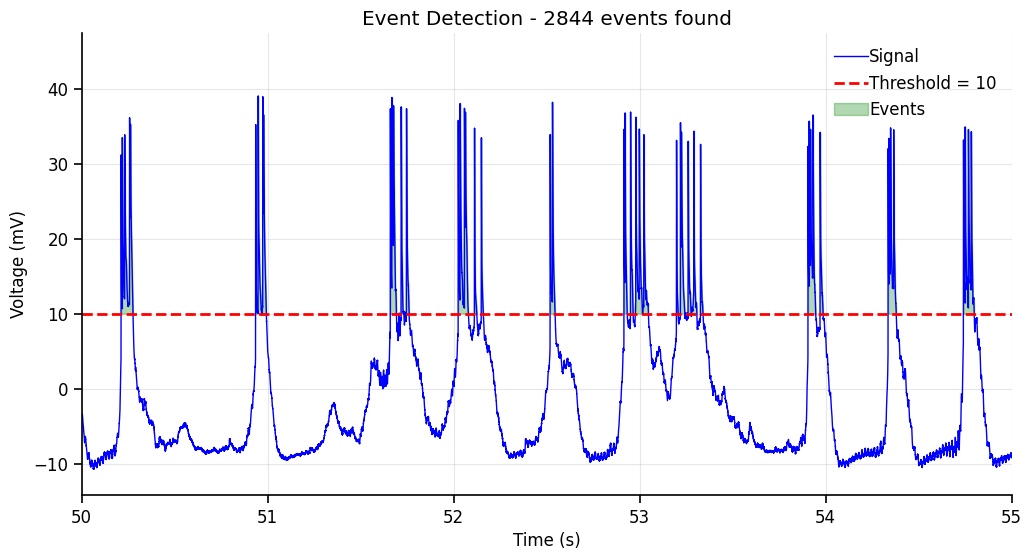

In [52]:
%matplotlib inline
threshold = 10
results, ax = analyze_threshold_events(traces.time, traces.voltage_data, threshold=threshold, plot=True, xlim=(50,55))

print(f"Number of events: {results['num_events']}")
print(f"Total area above threshold: {results['total_area']:.2f}")
print(f"Individual event areas: {[f'{area:.2f}' for area in results['event_areas']]}")
print(f"Event durations: {[f'{dur:.3f}' for dur in results['event_durations']]}")

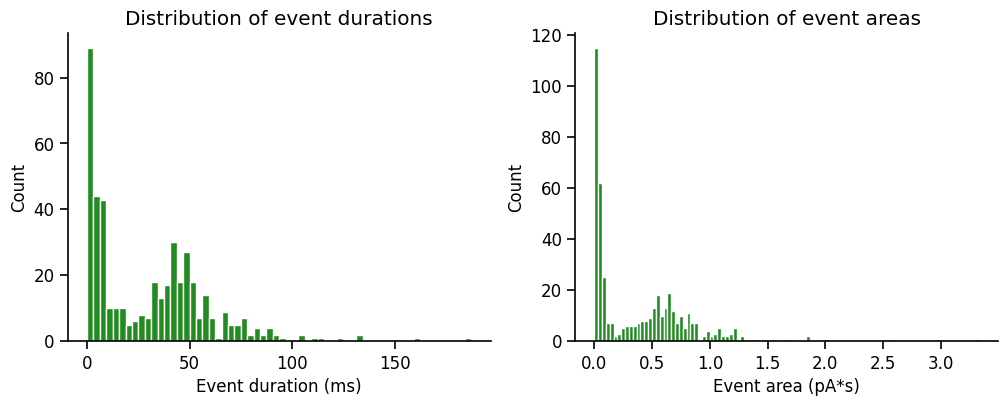

In [16]:
event_durations = np.array(results['event_durations'])*1000
fig, ax = plt.subplots(1,2, figsize=(12, 4))
ax[0].hist(event_durations, bins=60, color='forestgreen', edgecolor='white')
ax[0].set_xlabel('Event duration (ms)')
ax[0].set_ylabel('Count')
# ax[0].set_yscale('log')
ax[0].set_title('Distribution of event durations')

ax[1].hist(results['event_areas'], bins=100, color='forestgreen', edgecolor='white')
ax[1].set_xlabel('Event area (pA*s)')
ax[1].set_ylabel('Count')
# ax[1].set_xlim(0, 16)
# ax[1].set_yscale('log')
ax[1].set_title('Distribution of event areas')
plt.show()

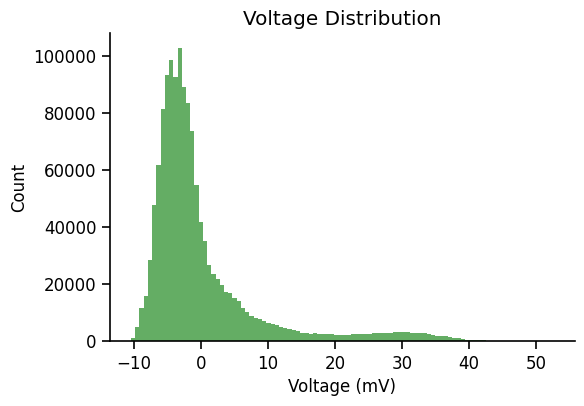

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.hist(traces.voltage_data, bins=100, color='forestgreen', alpha=0.7)
ax.set_xlabel('Voltage (mV)')
ax.set_ylabel('Count')
ax.set_title('Voltage Distribution')
plt.show()

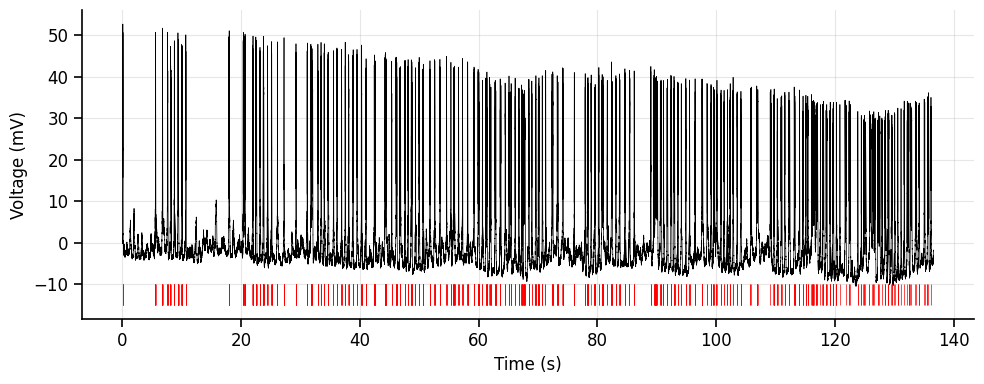

In [30]:
spike_times = spike_results['spike_times'] / 1000
# y_axis_range = (-0, 100)

%matplotlib inline
ax = traces.plot(plot_voltage=True, plot_current=False)
ax.vlines(spike_times, -15, -10, color='r', linewidth=0.5)
# ax.set_ylim(y_axis_range)
# ax.set_xlim(220, 222)
# ax.set_xlim(149, 150)
plt.show()


Spike Property Summary:
--------------------------------------------------
Total spikes analyzed: 865

Peak Voltages (mV):
  Mean ± SD: 40.6 ± 5.8
  Range: [25.9, 52.6]

Spike Amplitudes (mV):
  Mean ± SD: 32.6 ± 4.5
  Range: [25.0, 46.5]

Spike Widths (ms):
  Mean ± SD: 14.65 ± 7.22
  Range: [2.00, 24.90]


(<Figure size 1200x400 with 3 Axes>,
 array([<AxesSubplot: title={'center': 'Peak Voltages'}, xlabel='Peak Voltages (mV)', ylabel='Count'>,
        <AxesSubplot: title={'center': 'Spike Amplitudes'}, xlabel='Spike Amplitudes (mV)', ylabel='Count'>,
        <AxesSubplot: title={'center': 'Spike Widths'}, xlabel='Spike Widths (ms)', ylabel='Count'>],
       dtype=object),
 {'peak_voltages': {'mean': 40.601902341493854,
   'std': 5.790804343036918,
   'min': 25.93447454388854,
   'max': 52.63171046056113,
   'n': 865},
  'spike_amplitudes': {'mean': 32.60950182311479,
   'std': 4.470795624049851,
   'min': 25.034980079078572,
   'max': 46.52736195384924,
   'n': 865},
  'spike_widths': {'mean': 14.646820809248554,
   'std': 7.224044129998663,
   'min': 2.0,
   'max': 24.900000000000002,
   'n': 865}})

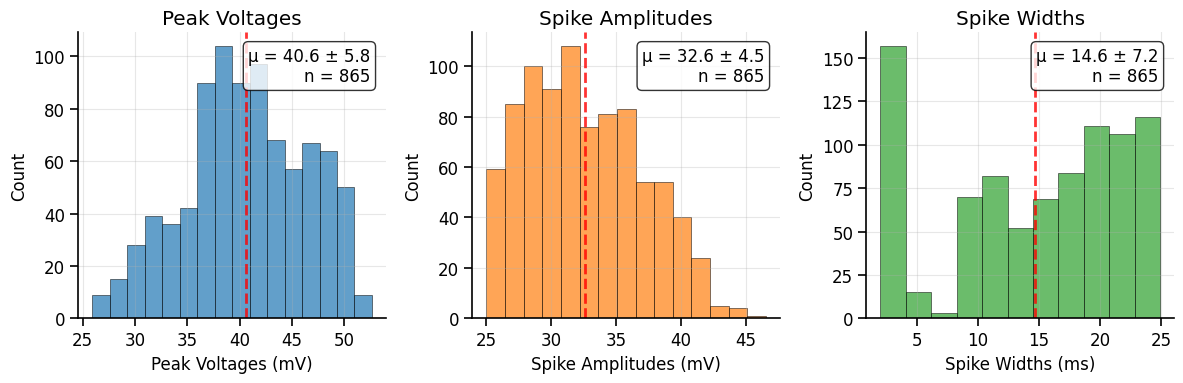

In [31]:
%matplotlib inline
plot_spike_histograms(spike_results)

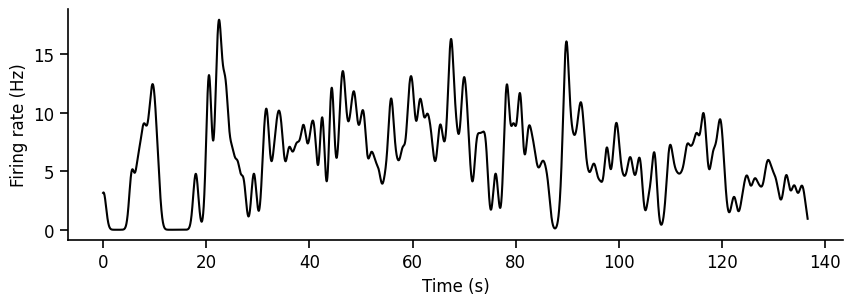

In [35]:
duration = traces.total_time
sampling_rate = traces.sampling_rate
time, firing_rate = fast_firing_rate(spike_times, duration, sampling_rate, sigma_ms=sampling_rate/20)

%matplotlib inline
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
ax.plot(time,firing_rate, color='k')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Firing rate (Hz)')
plt.show()